In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

SEED = 0

## Load dataset

In [22]:
df = pd.read_csv('../diabetes_prediction_dataset.csv')

## Perform cleaning and preprocessing

### Detect and remove invalid values

In [23]:
# Make a dataframe to count the null, na, and negative values
invalid_values = pd.DataFrame()
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
      invalid_values[col] = [df[col].isnull().sum(), df[col].isna().sum(), (df[col] < 0).sum()]
    else:
      invalid_values[col] = [df[col].isnull().sum(), df[col].isna().sum(), np.NaN]
invalid_values.index = ['Null count', 'NaN count', 'Negative count']

display(invalid_values)
print('There are no null, NaN, or negative values in the dataset that need cleaning.\n')

print(f'Duplicated Rows: {df.duplicated().sum()}')
# There are 3854 duplicate rows, let's drop them
df_clean = df.drop_duplicates()

# There are 3998 "ever" values in the 'smoking_history' column, this looks like a typo
# So let's replace it with 'never'
print(f'''
There are {len(df_clean[df_clean['smoking_history'] == 'ever'])} "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".
''')
df_clean.loc[df_clean['smoking_history'] == 'ever', 'smoking_history'] = 'never'

print(f'There are {len(df_clean)} clean rows left after dropping duplicates.')

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
Null count,0.0,0,0,0,0.0,0,0,0,0
NaN count,0.0,0,0,0,0.0,0,0,0,0
Negative count,NaN,0,0,0,NaN,0,0,0,0


There are no null, NaN, or negative values in the dataset that need cleaning.

Duplicated Rows: 3854

There are 3998 "ever" values in the smoking_history column.
This looks like a typo, so we will replace it with "never".

There are 96146 clean rows left after dropping duplicates.


### Preprocess data into numerical and categorical features

In [24]:
categorical_columns = set(['diabetes', 'heart_disease', 'hypertension', 'gender', 'smoking_history'])
df_quantitative_columns = set(df_clean.columns).difference(set(categorical_columns))
df_quantitative = df_clean[list(df_quantitative_columns)]
df_categorical = df_clean[list(categorical_columns)]

# Models Implementation

In [25]:
import seaborn as sns
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def report_model_performance(y_test, y_pred, model_name):
  accuracy = accuracy_score(y_test, y_pred)
  print(f'{model_name} Accuracy: {accuracy:.2f}')
  print(classification_report(y_test, y_pred, target_names=['No Diabetes', 'Diabetes']))

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
              xticklabels=['No Diabetes', 'Diabetes'], 
              yticklabels=['No Diabetes', 'Diabetes'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title(f'Confusion Matrix for {model_name}')
  plt.show()

## Generalized Linear Model

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               diabetes   No. Observations:                76916
Model:                            GLM   Df Residuals:                    76910
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23927.
Date:                Tue, 10 Jun 2025   Deviance:                       47855.
Time:                        22:11:43   Pearson chi2:                 2.09e+05
No. Iterations:                     6   Pseudo R-squ. (CS):           -0.02392
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                     0.0161      0.001     27.063      0.000       0.015       0.017
hypertension            1.2919      0.036     36.110      0.000       1.222       1.362
heart_disease           1.1372      0.045     25.324      0.000       1.049       1.225
bmi                    -0.1240      0.002    -59.171      0.000      -0.128      -0.120
HbA1c_level            -0.2065      0.009    -22.960      0.000      -0.224      -0.189
blood_glucose_level     0.0096      0.000     34.502      0.000       0.009       0.010
=======================================================================================
"""

Generalized Linear Model Accuracy: 0.91
              precision    recall  f1-score   support

 No Diabetes       0.92      0.99      0.95     17562
    Diabetes       0.41      0.06      0.10      1668

    accuracy                           0.91     19230
   macro avg       0.66      0.52      0.53     19230
weighted avg       0.87      0.91      0.88     19230



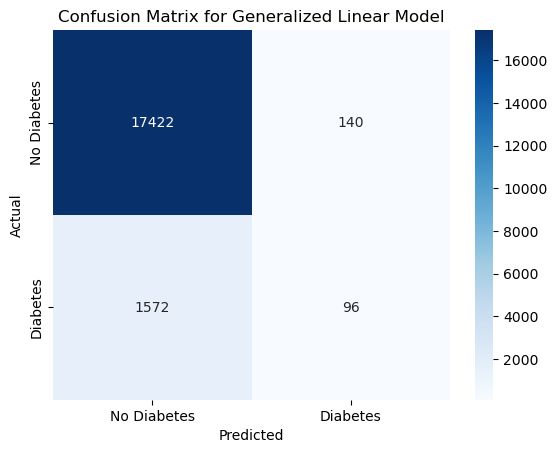

In [26]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
  df_clean[["age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level"]],
  df_clean['diabetes'],
  test_size=0.2)

glm = sm.GLM(
        y_train,
        X_train,
        family=sm.families.Binomial()).fit()

display(glm.summary())

y_glm = glm.predict(X_test) > 0.5
report_model_performance(y_test, y_glm, 'Generalized Linear Model')

## Logistic Regression

Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

 No Diabetes       0.97      0.99      0.98     17562
    Diabetes       0.87      0.63      0.73      1668

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.85     19230
weighted avg       0.96      0.96      0.96     19230



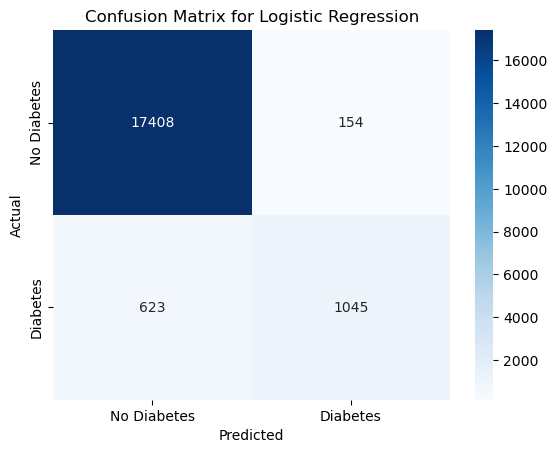

In [27]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
  df_clean[["age", "bmi", "HbA1c_level", "blood_glucose_level"]],
  df_clean['diabetes'],
  test_size=0.2)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_log_reg = log_reg.predict(X_test)

report_model_performance(y_test, y_log_reg, 'Logistic Regression')


## KMeans Clustering

KMeans Clustering Accuracy: 0.50
              precision    recall  f1-score   support

 No Diabetes       0.99      0.45      0.62     17562
    Diabetes       0.14      0.97      0.25      1668

    accuracy                           0.50     19230
   macro avg       0.57      0.71      0.44     19230
weighted avg       0.92      0.50      0.59     19230



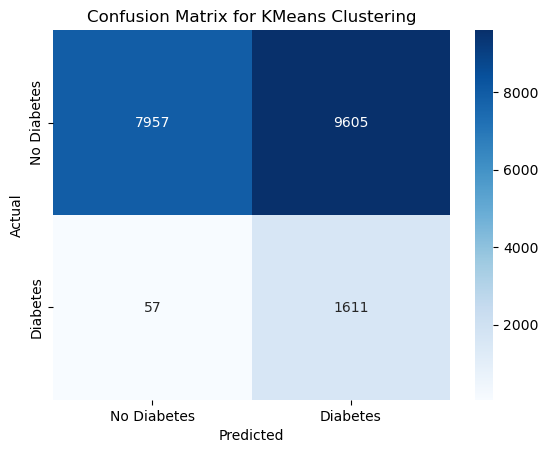

In [28]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
  df_clean[["age", "bmi", "blood_glucose_level"]],
  df_clean['diabetes'],
  test_size=0.2)

scaler = StandardScaler()
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaler.fit_transform(X_train))
y_kmeans = kmeans.predict(scaler.transform(X_test))

report_model_performance(y_test, y_kmeans, 'KMeans Clustering')


## K-Nearest Neighbors

KNN Accuracy: 0.94
              precision    recall  f1-score   support

 No Diabetes       0.95      0.99      0.97     17562
    Diabetes       0.79      0.45      0.57      1668

    accuracy                           0.94     19230
   macro avg       0.87      0.72      0.77     19230
weighted avg       0.94      0.94      0.93     19230



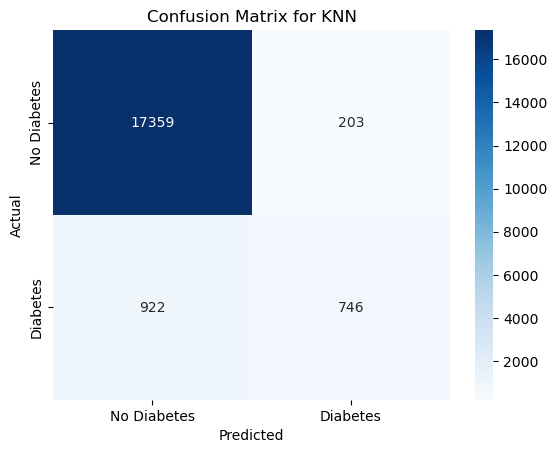

In [29]:
np.random.seed(SEED)

X_train, X_test, y_train, y_test = train_test_split(
  df_clean[["age", "bmi", "blood_glucose_level"]],
  df_clean['diabetes'],
  test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

report_model_performance(y_test, y_knn, 'KNN')
